# Временные ряды: прогнозирование спроса на такси

Некая компания, работающая на рынке такси, обладает историческими данными о заказах такси и хочет использовать их для __прогнозирования спроса на такси (количество заказов) на следующий час__, чтобы оптимизировать управление количеством водителей.  

Необходимо построить модель для такого предсказания. Заказчик требует, чтобы значение *RMSE* на тестовой выборке было не больше 48.

# 1. Подготовка

Загрузим необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import copy

import matplotlib.pyplot as plt

In [2]:
from statsmodels.tsa.statespace import sarimax

Определим число, которое будем использовать в качестве зерна случайного состояния.

In [3]:
state = 12345

Загрузим необработанные данные и посмотрим на них.

In [4]:
df_raw = pd.read_csv('...')

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
df_raw.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Первый столбец - даты, которые мы назначим в качестве индексов. Прежде, чем двигаться дальше, сразу посмотрим, нет ли дубликатов среди дат. Повторы в целевом признаке вполне допустимы, но если повторяются даты - это ошибка.

In [7]:
df_raw.datetime.duplicated().sum()

0

Дубликатов среди дат нет. Назначим даты индексами, переведем их в подходящий формат datetime, упорядочим их.

In [8]:
df_raw.datetime = pd.to_datetime(df_raw.datetime)
df_raw.set_index('datetime', drop = True, inplace = True)
df_raw = df_raw.sort_index()
df_raw.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [9]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, монотонны ли они.

In [10]:
df_raw.index.is_monotonic

True

Проверим, нет ли пропусков среди целевого признака.

In [11]:
df_raw[df_raw['num_orders'].isnull()==True]

,num_orders
datetime,


Произведем ресемплирование по одному часу.

In [12]:
df = df_raw.resample('1H').sum()
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [13]:
df.min()

num_orders    0
dtype: int64

In [14]:
df.max()

num_orders    462
dtype: int64

In [15]:
df.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

In [16]:
df.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

Минимальное значение ресемплированных данных нулевое, что соответствует здравому смыслу. Данные готовы для анализа.

# 2. Анализ

Построим график по почасовой разбивке данных.

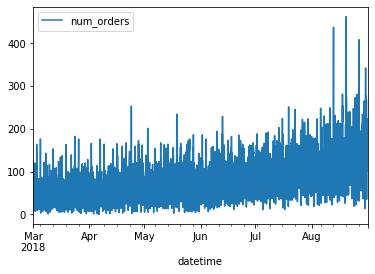

In [17]:
df.plot()

Можно заметить небольшое слабо различимое увеличение количества заказов в час с течением времени (судя по нижней границе - с июня) и будто бы увеличение разброса данных ближе к концу выборки. В целом, график плохо читается, произведем декомпозицию: вычленим из данных тренд, сезонность и остатки. 

In [18]:
df_decomposed = seasonal_decompose(df)
trend = df_decomposed.trend
seasonality = df_decomposed.seasonal
residuals = df_decomposed.resid

Text(0.5, 1.0, 'residuals')

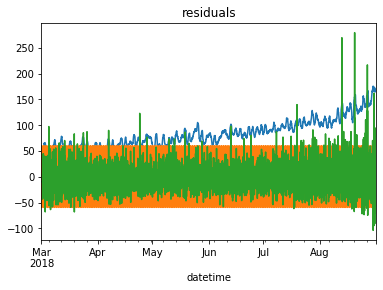

In [19]:
trend.plot()
plt.title('trend')
seasonality.plot()
plt.title('seasonality')
residuals.plot()
plt.title('residuals')


График тренда частично подтверждает нашу догадку о наличии долгосрочного тренда, хотя на он наличествовал до июня. Чуть более читаемый график тренда можно получить, если еще больше сгладить флуктуации, выбрав для скользящего среднего большее окно.

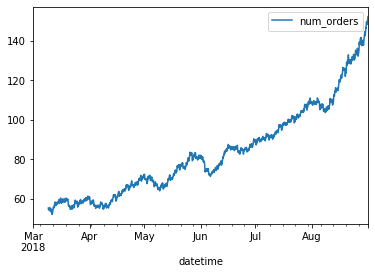

In [20]:
df.rolling(200).mean().plot()

График сезонных колебаний абсолютно не читаем из-за высокой частоты. Значит, сезонный цикл существует на малых временных диапазонах. Если учесть, что мы ресемплировали данные по часу, вполне возможно, сезонность имееет место внутри суток.  
Посмотрим на поведение количества заказов в диапазоне десяти дней.

Text(0.5, 1.0, 'seasonality')

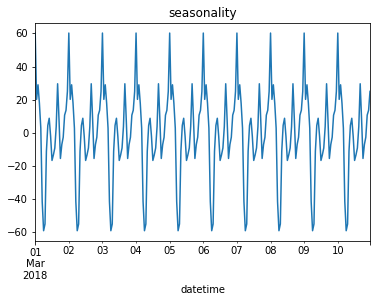

In [21]:
seasonality['2018-03-01':'2018-03-10'].plot()
plt.title('seasonality')

Text(0.5, 1.0, 'seasonality')

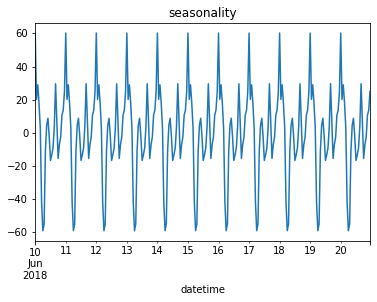

In [22]:
seasonality['2018-06-10':'2018-06-20'].plot()
plt.title('seasonality')

Text(0.5, 1.0, 'seasonality')

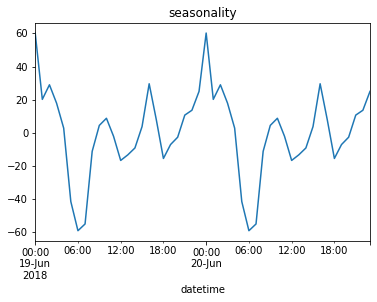

In [23]:
seasonality['2018-06-19':'2018-06-20'].plot()
plt.title('seasonality')

Видим идентичные колебания внутри одного дня. Самый низкий спрос на такси в 6 часов утра, затем резкий рост до локального пика между 6 и 12 часами дня, затем локальный пик между 12 и 18 часами и суточный пик полночь, после чего идет довольно резкое падение до минимума в 6 часов утра.  
Однако руководствуясь общими представлениями о работе такси можно предположить, что периодические колебания могут быть не только внутри одних суток, но и в течение недели, поскольку нагрузка на такси, скорее всего, варьируется в зависимости от того, будний ли день или выходной.  
Проверим это предположение. Ресемлируем данные по одному дню и посмотрим на флуктуации в пределах одного месяца.

In [24]:
df_day = copy.deepcopy(df).resample('1D').sum()

In [25]:
df_day

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259
...,...
2018-08-27,3936
2018-08-28,3357
2018-08-29,3762


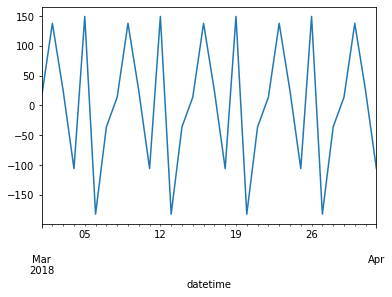

In [26]:
df_day_decomposed = seasonal_decompose(df_day)
df_day_decomposed.seasonal['2018-03-01':'2018-04-01'].plot()

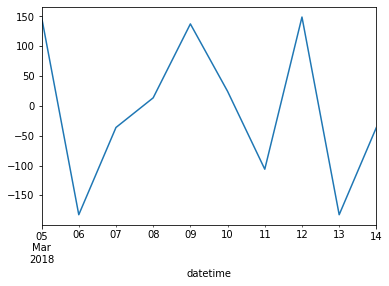

In [27]:
df_day_decomposed.seasonal['2018-03-05':'2018-03-14'].plot()

Действительно, наблюдается цикл в 7 дней. Установим, в какой день самый низкий спрос. Добавим столбец с днями недели и выведем промежуток с графика.

In [28]:
df_day['dayofweek'] = df_day.index.dayofweek
df_day['2018-03-05':'2018-03-13']

,num_orders,dayofweek
datetime,,
2018-03-05,1259,0
2018-03-06,1109,1
2018-03-07,1441,2
2018-03-08,1659,3
2018-03-09,1076,4
2018-03-10,1267,5
2018-03-11,1600,6
2018-03-12,1622,0
2018-03-13,1369,1


Соотнеся дни недели с датами на графике сезонности, можно прийти к выводу, что минимум заказов поступает во вторник, затем он поднимается до локального максимума в пятницу, потом он опускается за выходные, но затем опять увеличивается к понедельнику. Что довольно контринтуитивно.  

Тем не менее, мы установили, что помимо сезонности внутри суток есть так же более глобальная недельная сезонность. Из этого мы выдвигаем предположение, что модель будет лучше работать, если у нее будут данные не только о лаге внутри суток, благодаря которому она сможет определить особенности каждого часа суток, но и о дне недели. Возможно, также будет иметь смысл увеличить количество учитываемых лагов за прделы 24 часов, чтобы модель могла учесть недельную перспективу.

### Вывод

Удалось выявить сезонность в пределах суток и в пределах недели.

# 3. Обучение

Определим функцию, которая добавляла бы данные по году, месяцу, календарному числу, а также, что более важно, дню недели. Также функция добавляла бы данные о лаге (часовом в нашем случае) за передаваемое функции количество часов - по столбцу за каждый час - и значения скальзящей средней в передаваемом функции временном окне.

In [29]:
def make_features(incoming_data, max_lag, rolling_mean_size):
    data = copy.deepcopy(incoming_data)
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

Опробуем несколько вариантов максимального лага и временного окна. Эмпирически можно установить, что тренд становится четче виден при достаточно большом временном окне, больше ста часов (мы использовали 200 часов, когда анализировали тренд с помощью скользящего среднего). Исходя из нашей предпосылки о сезонности внутри суток, можно предположить, что максимальный лаг стоит передавать не менее суток, а исходя из предпосылки о сезонности внутри недели можно предположить, что увеличение максимального лага до количества часов в неделе так же скорректирует прогноз модели, хотя для этого у нас есть признак dayofweek.  
Тем не менее, чтобы полноценно проверить наше предположение, стоит опробовать и варианты с небольшим окном и максимальным лагом. Поэтому начнем с небольших значений.

In [30]:
df_5_10 = make_features(df, 5, 10)
df_5_10.head(10)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,2018,3,1,3,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 06:00:00,12,2018,3,1,3,6.0,43.0,66.0,71.0,85.0,NaN
2018-03-01 07:00:00,15,2018,3,1,3,12.0,6.0,43.0,66.0,71.0,NaN
2018-03-01 08:00:00,34,2018,3,1,3,15.0,12.0,6.0,43.0,66.0,NaN


In [31]:
df_5_10.tail()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,173.3
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,166.6
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,162.9
2018-08-31 22:00:00,223,2018,8,31,4,159.0,154.0,136.0,207.0,217.0,162.1
2018-08-31 23:00:00,205,2018,8,31,4,223.0,159.0,154.0,136.0,207.0,170.8


In [32]:
df_25_50 = make_features(df, 25, 50)
df_25_50.head(10)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,2018,3,1,3,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,2018,3,1,3,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,2018,3,1,3,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,2018,3,1,3,15.0,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_48_100 = make_features(df, 48, 100)
df_48_100.head(10)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,2018,3,1,3,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,2018,3,1,3,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,2018,3,1,3,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,2018,3,1,3,15.0,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Наконец, попробуем передать модели данные с максимальным лагом, равным полному циклу недельной сезонности. Это будет большая таблица с полутораста признаками, но попробовать стоит.

In [34]:
7*24

168

In [35]:
df_168_100 = make_features(df, 168, 100)
df_168_100.head(10)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,2018,3,1,3,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,2018,3,1,3,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,2018,3,1,3,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,2018,3,1,3,15.0,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Линейная регрессия

Удалим из данных образовавшиеся пропуски и обучим модель. Разбивать данные на выборки придется для каждого варианта данных.

In [36]:
df_5_10 = df_5_10.dropna()
features_train_valid_5_10, features_test_5_10, target_train_valid_5_10, target_test_5_10 = train_test_split(
    df_5_10.drop('num_orders', axis = 1), df_5_10.num_orders, shuffle = False, test_size = 0.1)
features_train_5_10, features_valid_5_10, target_train_5_10, target_valid_5_10 = train_test_split(
    df_5_10.drop('num_orders', axis = 1), df_5_10.num_orders, shuffle = False, test_size = 0.1)


In [37]:
lin_reg = LinearRegression()
lin_reg.fit(features_train_5_10, target_train_5_10)
predicted_train_5_10 = lin_reg.predict(features_train_5_10)
predicted_valid_5_10 = lin_reg.predict(features_valid_5_10)
rmse_train_5_10 = mean_squared_error(target_train_5_10, predicted_train_5_10) ** 0.5
rmse_valid_5_10 = mean_squared_error(target_valid_5_10, predicted_valid_5_10) ** 0.5
rmse_train_5_10

30.504654650328636

In [38]:
rmse_valid_5_10

53.369220885358075

Линейная регрессия на данных с небольшим лагом и окном показала неудовлетворительный результат на валидационной выборке.

In [39]:
df_25_50 = df_25_50.dropna()
features_train_valid_25_50, features_test_25_50, target_train_valid_25_50, target_test_25_50 = train_test_split(
    df_25_50.drop('num_orders', axis = 1), df_25_50.num_orders, shuffle = False, test_size = 0.1)
features_train_25_50, features_valid_25_50, target_train_25_50, target_valid_25_50 = train_test_split(
    df_25_50.drop('num_orders', axis = 1), df_25_50.num_orders, shuffle = False, test_size = 0.1)


In [40]:
lin_reg = LinearRegression()
lin_reg.fit(features_train_25_50, target_train_25_50)
predicted_train_25_50 = lin_reg.predict(features_train_25_50)
predicted_valid_25_50 = lin_reg.predict(features_valid_25_50)
rmse_train_25_50 = mean_squared_error(target_train_25_50, predicted_train_25_50) ** 0.5
rmse_valid_25_50 = mean_squared_error(target_valid_25_50, predicted_valid_25_50) ** 0.5
rmse_train_25_50

25.76215380921594

In [41]:
rmse_valid_25_50

46.67086842956129

Предсказания линейной регрессии, обученной на данных с максимальным лагом, превышающим сутки, в пределах которых наблюдается паттерн, показали удовлетворительные результаты на валидационной выборке, хотя на тестовой выборке результат может оказаться неудовлетворительным.

In [42]:
df_48_100 = df_48_100.dropna()
features_train_valid_48_100, features_test_48_100, target_train_valid_48_100, target_test_48_100 = train_test_split(
    df_48_100.drop('num_orders', axis = 1), df_48_100.num_orders, shuffle = False, test_size = 0.1)
features_train_48_100, features_valid_48_100, target_train_48_100, target_valid_48_100 = train_test_split(
    df_48_100.drop('num_orders', axis = 1), df_48_100.num_orders, shuffle = False, test_size = 0.1)


In [43]:
lin_reg = LinearRegression()
lin_reg.fit(features_train_48_100, target_train_48_100)
predicted_train_48_100 = lin_reg.predict(features_train_48_100)
predicted_valid_48_100 = lin_reg.predict(features_valid_48_100)
rmse_train_48_100 = mean_squared_error(target_train_48_100, predicted_train_48_100) ** 0.5
rmse_valid_48_100 = mean_squared_error(target_valid_48_100, predicted_valid_48_100) ** 0.5
rmse_train_48_100

23.36793890935455

In [44]:
rmse_valid_48_100

43.79799726588174

При обучении на данных с максимальным лагом, вдвое превышающим количество часов в сутках, и с большим окном для скользящего среднего, предсказания линейной регрессии на валидационной выборке еще лучше.

In [45]:
df_168_100 = df_168_100.dropna()
features_train_valid_168_100, features_test_168_100, target_train_valid_168_100, target_test_168_100 = train_test_split(
    df_168_100.drop('num_orders', axis = 1), df_168_100.num_orders, shuffle = False, test_size = 0.1)
features_train_168_100, features_valid_168_100, target_train_168_100, target_valid_168_100 = train_test_split(
    df_168_100.drop('num_orders', axis = 1), df_168_100.num_orders, shuffle = False, test_size = 0.1)


In [46]:
lin_reg = LinearRegression()
lin_reg.fit(features_train_168_100, target_train_168_100)
predicted_train_168_100 = lin_reg.predict(features_train_168_100)
predicted_valid_168_100 = lin_reg.predict(features_valid_168_100)
rmse_train_168_100 = mean_squared_error(target_train_168_100, predicted_train_168_100) ** 0.5
rmse_valid_168_100 = mean_squared_error(target_valid_168_100, predicted_valid_168_100) ** 0.5
rmse_train_168_100

20.452645121868983

In [47]:
rmse_valid_168_100

35.26035251432641

Линейная регрессия дала лучшие предсказания на валидационной выборке при повышении максимального лага до количества часов в неделе, при этом окно скользящего среднего осталось таким же, как в предыдущем варианте данных, а скачок качества предсказания с измененим вводных даже больше, чем предыдущий.

## Случайный лес

Определим функцию, которая принимала бы целевые и не целевые признаки обучающей и валидационной выборок и выдавала бы таблицу с результатами предсказаний моделей случайного леса с разными гиперпараметрами.

In [48]:
%%time
def forest_search(features_train, target_train, features_valid, target_valid):
    forest_depth_col = []
    forest_estim_col = []
    forest_score_col = []
    for depth in [8, 12,18]:
        for n_estim in [80, 120, 150]:
            forest_model = RandomForestRegressor(n_estimators = n_estim, 
                                                   max_depth = depth, 
                                                   random_state = state)
            forest_model.fit(features_train, target_train)
            forest_predicted_valid = forest_model.predict(features_valid)
            rmse_score = mean_squared_error(target_valid, forest_predicted_valid) ** 0.5
            forest_depth_col.append(depth)
            forest_estim_col.append(n_estim)
            forest_score_col.append(rmse_score)
    forest_hyperparameters_dict = {'max_depth': forest_depth_col, 'n_estimators': forest_estim_col, 'rmse_score': forest_score_col}
    forest_hyperparameters = pd.DataFrame(data = forest_hyperparameters_dict)
    return forest_hyperparameters


Wall time: 0 ns


Передадим функции данные с разными значениями максимального лага и окна скользящего среднего.

In [49]:
%%time 
forests_5_10 = forest_search(features_train_5_10, target_train_5_10, features_valid_5_10, target_valid_5_10)
forests_5_10

Wall time: 9.22 s


,max_depth,n_estimators,rmse_score
0,8,80,58.449892
1,8,120,58.015650
2,8,150,57.903874
3,12,80,58.009969
4,12,120,57.222819
5,12,150,57.190615
6,18,80,57.560116
7,18,120,57.205191
8,18,150,56.928036


Ни один из вариантов случайного леса не дал удовлетворительного результата на данных с малыми значениями максимального лага и окна.

In [50]:
%%time 
forests_25_50 = forest_search(features_train_25_50, target_train_25_50, features_valid_25_50, target_valid_25_50)
forests_25_50

Wall time: 29.5 s


,max_depth,n_estimators,rmse_score
0,8,80,45.596302
1,8,120,45.478331
2,8,150,45.571012
3,12,80,45.002976
4,12,120,44.733580
5,12,150,44.685014
6,18,80,44.226556
7,18,120,43.971499
8,18,150,43.985234


Лучший вариант случайного леса дает чуть лучшие результаты предсказаний на валидационной выборке, чем линейная регрессия, обученная на том же наборе данных.

In [51]:
%%time 
forests_48_100 = forest_search(features_train_48_100, target_train_48_100, features_valid_48_100, target_valid_48_100)
forests_48_100

Wall time: 50.7 s


,max_depth,n_estimators,rmse_score
0,8,80,42.077140
1,8,120,42.122316
2,8,150,42.240243
3,12,80,41.546824
4,12,120,41.527589
5,12,150,41.504601
6,18,80,41.253668
7,18,120,41.192328
8,18,150,41.166678


Аналогично, лучший вариант случайного леса дает чуть лучшие результаты предсказаний на валидационной выборке, чем линейная регрессия, обученная на том же наборе данных с большими значениями окна и лага.

In [52]:
%%time 
forests_168_100 = forest_search(features_train_168_100, target_train_168_100, features_valid_168_100, target_valid_168_100)
forests_168_100

Wall time: 2min 43s


,max_depth,n_estimators,rmse_score
0,8,80,39.649474
1,8,120,39.805153
2,8,150,39.634987
3,12,80,39.546121
4,12,120,39.866676
5,12,150,39.701898
6,18,80,39.372489
7,18,120,39.610129
8,18,150,39.333529


Интересно, что обучение случайного леса на наборе данных с наибольшим лагом улучшило результат случайного леса, но не в той же степени, что в случае линейной регрессии. Случайный лес уступает линейной регрессии по качеству предсказания на валидационной выборке.

### Вывод

Тестировать мы будем линейную регрессию, обученную на наборе данных с недельным почасовым максимальным лагом и окном скользящего среднего в 100 часов.

# 4. Тестирование

Обучим модель на данных, включающих и обучающую, и тестовую выборки.

In [53]:
best_lin_reg = LinearRegression()
best_lin_reg.fit(features_train_valid_168_100, target_train_valid_168_100)

LinearRegression()

In [54]:
predicted_test_168_100 = best_lin_reg.predict(features_test_168_100)
rmse_test_168_100 = mean_squared_error(target_test_168_100, predicted_test_168_100) ** 0.5
rmse_test_168_100

35.26035251432641

Нам удалось получить предсказания на тестовой выборке, значение RMSE которых не превышает 48 и значительно ниже аналогичного показателя предсказаний на валидационной выборке, полученных на наборе данных с меньшим значением максимального лага. Предположение, выдвинутое на основании анализа, подтвердилось, а модель можно передавать заказчику.